In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor
from datetime import timedelta
from sklearn.ensemble import RandomForestRegressor

In [2]:
df=pd.read_csv("energy_dataset.csv")

In [3]:
df.head(7)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,...,191.0,0.0,5238.0,2.0,NaN,5151.0,22642.0,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,...,189.0,0.0,4935.0,9.0,NaN,4861.0,21785.0,20264.0,38.41,56.04
5,2015-01-01 05:00:00+01:00,410.0,178.0,0.0,4038.0,3590.0,156.0,0.0,0.0,0.0,...,188.0,0.0,4618.0,4.0,NaN,4617.0,21441.0,19905.0,35.72,53.63
6,2015-01-01 06:00:00+01:00,401.0,172.0,0.0,4040.0,3368.0,158.0,0.0,0.0,0.0,...,186.0,0.0,4397.0,3.0,NaN,4276.0,21285.0,20010.0,35.13,51.73


In [4]:
# We MUST convert the 'time' column from simple text (string) into a special 
print("Converting 'time' column to Datetime format...")
df['time'] = pd.to_datetime(df['time'], utc=True)

#making the DataFRame to 'time' coloumn as its index 
df.set_index('time', inplace=True)

#sorting data from oldest time to newest time
df.sort_index(inplace=True)

# We check for missing values (NaN) in every column.
print("\nChecking for Missing Values (NaN) in each column:")
print(df.isnull().sum())

# Assigning the target variable (the 'y' variable).
TARGET_VARIABLE = 'total load actual'

print(f"Data is now indexed by time and ready for analysis.")
print(f"Our goal is to predict: {TARGET_VARIABLE}")

Converting 'time' column to Datetime format...

Checking for Missing Values (NaN) in each column:
generation biomass                                19
generation fossil brown coal/lignite              18
generation fossil coal-derived gas                18
generation fossil gas                             18
generation fossil hard coal                       18
generation fossil oil                             19
generation fossil oil shale                       18
generation fossil peat                            18
generation geothermal                             18
generation hydro pumped storage aggregated     35064
generation hydro pumped storage consumption       19
generation hydro run-of-river and poundage        19
generation hydro water reservoir                  18
generation marine                                 19
generation nuclear                                17
generation other                                  18
generation other renewable                        18
g

In [5]:
# the target variable ('total load actual') has 36 missing values.
# filling these gaps using the value from the previous hour (Forward Fill or 'ffill').

print("Filling 36 missing values in the target column...")

df['total load actual'] = df['total load actual'].ffill()

# Now, confirm the fix for the target variable:
target_na_count = df['total load actual'].isnull().sum()
print(f"Missing values in target column after fill: {target_na_count}")

# define columns to drop
columns_to_drop = [
    'generation hydro pumped storage aggregated',
    'forecast wind offshore eday ahead',
    'generation fossil coal-derived gas',
    'generation fossil oil shale',
    'generation fossil peat',
    'generation geothermal',
    'generation marine'
]

print(f"\nDropping {len(columns_to_drop)} columns that are mostly empty or irrelevant for the first model.")
df.drop(columns=columns_to_drop, inplace=True)

print("Data cleaning is now focused on the reliable generation sources.")
print(f"Current number of columns: {df.shape[1]}")

Filling 36 missing values in the target column...
Missing values in target column after fill: 0

Dropping 7 columns that are mostly empty or irrelevant for the first model.
Data cleaning is now focused on the reliable generation sources.
Current number of columns: 21


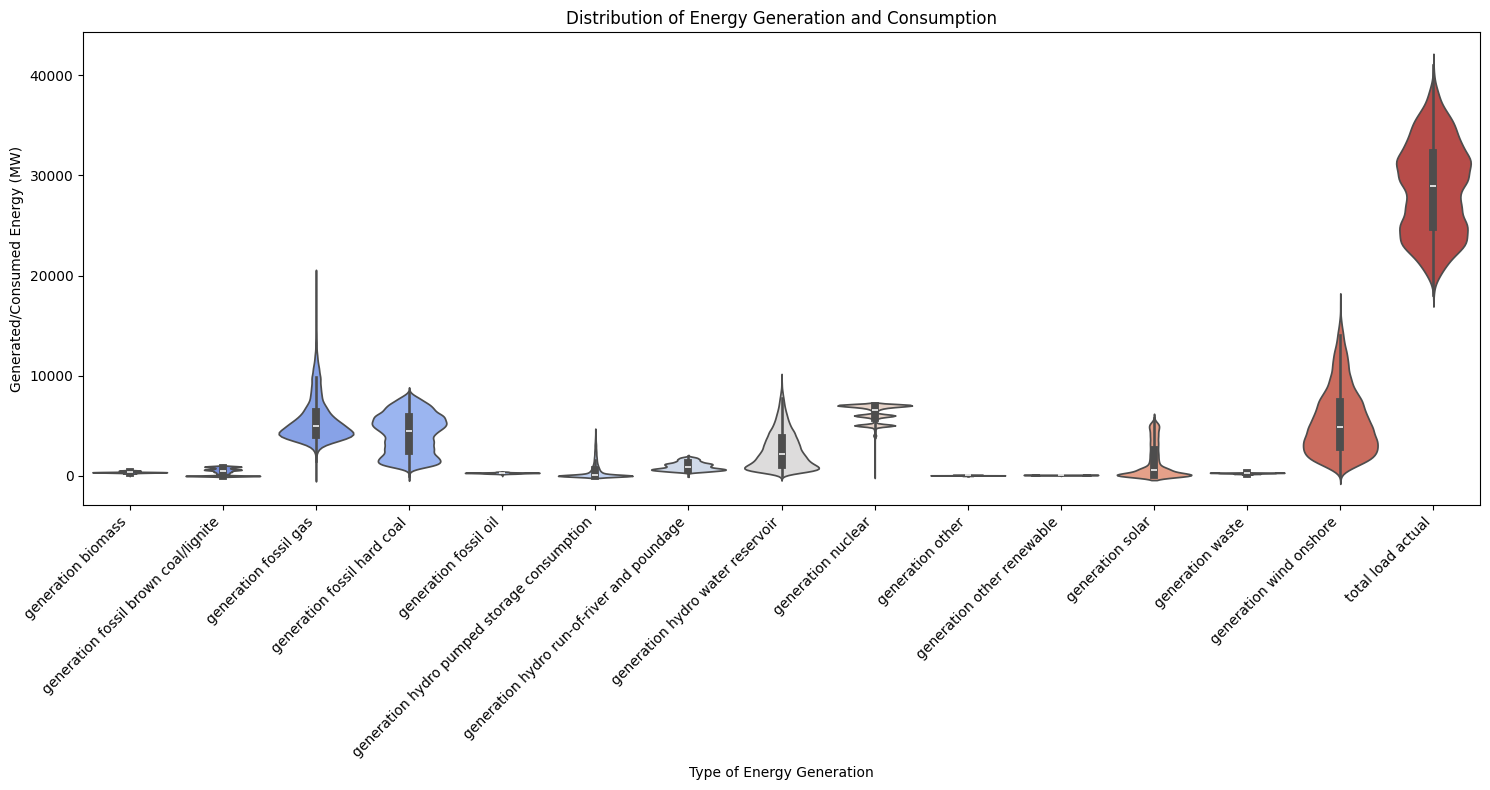

In [6]:
# Define the columns to plot
columns_to_plot = [
    'generation biomass',
    'generation fossil brown coal/lignite',
    'generation fossil gas',
    'generation fossil hard coal',
    'generation fossil oil',
    'generation hydro pumped storage consumption',
    'generation hydro run-of-river and poundage',
    'generation hydro water reservoir', 
    'generation nuclear',
    'generation other',
    'generation other renewable', 
    'generation solar',
    'generation waste',
    'generation wind onshore', 
    'total load actual'
]

# Filter the dataframe to only include the desired columns
data_to_plot = df[columns_to_plot]

# Melt the data so that we have one column for variable names and one for values 
data_long = pd.melt(data_to_plot, var_name='Type of Generation', value_name='Generation Output (MW)')

# Set a custom color palette
palette = sns.color_palette("coolwarm", len(columns_to_plot))

# Create the violin plot
plt.figure(figsize=(15, 8))
sns.violinplot(x='Type of Generation', y='Generation Output (MW)', data=data_long, 
               hue='Type of Generation', palette=palette, legend=False)

# Improve the aesthetics for readability
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.title('Distribution of Energy Generation and Consumption')
plt.xlabel('Type of Energy Generation')
plt.ylabel('Generated/Consumed Energy (MW)')

# Show the plot
plt.tight_layout()  # Adjusts the plot to fit the labels
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35064 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 21 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   generation biomass                           35045 non-null  float64
 1   generation fossil brown coal/lignite         35046 non-null  float64
 2   generation fossil gas                        35046 non-null  float64
 3   generation fossil hard coal                  35046 non-null  float64
 4   generation fossil oil                        35045 non-null  float64
 5   generation hydro pumped storage consumption  35045 non-null  float64
 6   generation hydro run-of-river and poundage   35045 non-null  float64
 7   generation hydro water reservoir             35046 non-null  float64
 8   generation nuclear                           35047 non-null  float64
 9   generation other         

In [8]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.000000,35046.000000,35045.000000,35045.000000,35045.000000,35046.000000,35047.000000,35046.000000,...,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000,35064.000000
mean,383.513540,448.059208,5622.737488,4256.065742,298.319789,475.577343,972.116108,2605.114735,6263.907039,60.228585,...,1432.665925,269.452133,0.0,5464.479769,1439.066735,5471.216689,28712.129962,28697.608573,49.874341,57.884023
std,85.353943,354.568590,2201.830478,1961.601013,52.520673,792.406614,400.777536,1835.199745,839.667958,20.238381,...,1680.119887,50.195536,0.0,3213.691587,1677.703355,3176.312853,4594.100854,4575.872425,14.618900,14.204083
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,4126.000000,2527.000000,263.000000,0.000000,637.000000,1077.250000,5760.000000,53.000000,...,71.000000,240.000000,0.0,2933.000000,69.000000,2979.000000,24793.750000,24806.750000,41.490000,49.347500
50%,367.000000,509.000000,4969.000000,4474.000000,300.000000,68.000000,906.000000,2164.000000,6566.000000,57.000000,...,616.000000,279.000000,0.0,4849.000000,576.000000,4855.000000,28906.000000,28902.000000,50.520000,58.020000
75%,433.000000,757.000000,6429.000000,5838.750000,330.000000,616.000000,1250.000000,3757.000000,7025.000000,80.000000,...,2578.000000,310.000000,0.0,7398.000000,2636.000000,7353.000000,32263.250000,32194.250000,60.530000,68.010000
max,592.000000,999.000000,20034.000000,8359.000000,449.000000,4523.000000,2000.000000,9728.000000,7117.000000,106.000000,...,5792.000000,357.000000,0.0,17436.000000,5836.000000,17430.000000,41390.000000,41015.000000,101.990000,116.800000


### Missing Data Strategy: Forward Fill (FFill) and Feature Selection

The raw data revealed two major issues: **36 missing values** in our target (`total load actual`) and over **35,000 missing values** in several obscure generation features.

#### Our Strategy Rationale:

1.  **Target Imputation (FFill):** i chose to fill the 36 missing target values using **Forward Fill (`ffill`)**.
    * **Why FFill?** Since energy load changes smoothly hour-to-hour, replacing a missing value with the previous hour's load introduces the least amount of artificial noise. This is safer than statistical imputation methods for a simple time series model. 

2.  **Dropping High-NaN Features:** i permanently removed columns with over 35,000 missing entries (like 'generation hydro pumped storage aggregated' and redundant generation types).
    * **Why Drop?** Columns with nearly 90% missing data are unusable. Attempting to fill them, even with advanced interpolation, would result in creating artificial data, severely degrading our model's credibility.

#### Critique of Alternative Methods (Addressing the Original Author):

The original notebook suggested using complex **Interpolation** for all missing data. i avoided this because:

* Interpolation works well for small, localized gaps, but it is **not suitable for filling large gaps** (like the 35,000 missing values).
* For the few remaining missing values in our final set, **FFill provides a simpler, more justifiable baseline** for a first-stage predictive model.


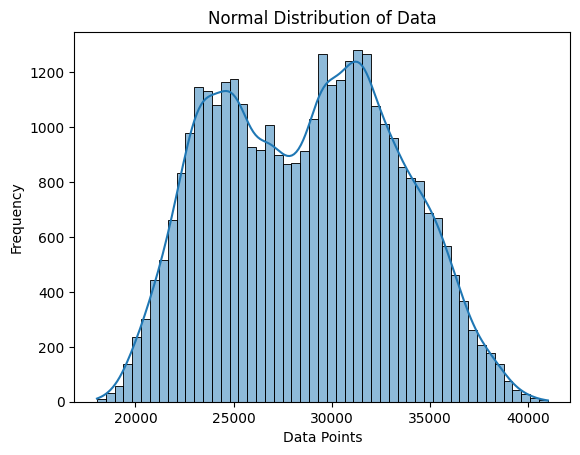

In [9]:
# Plotting the distribution
sns.histplot(df['total load actual'], kde=True)  # 'kde=True' adds the Kernel Density Estimate to smooth the histogram
plt.title('Normal Distribution of Data')
plt.xlabel('Data Points')
plt.ylabel('Frequency')
plt.show()


Now lets see using a line plot.

In [10]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

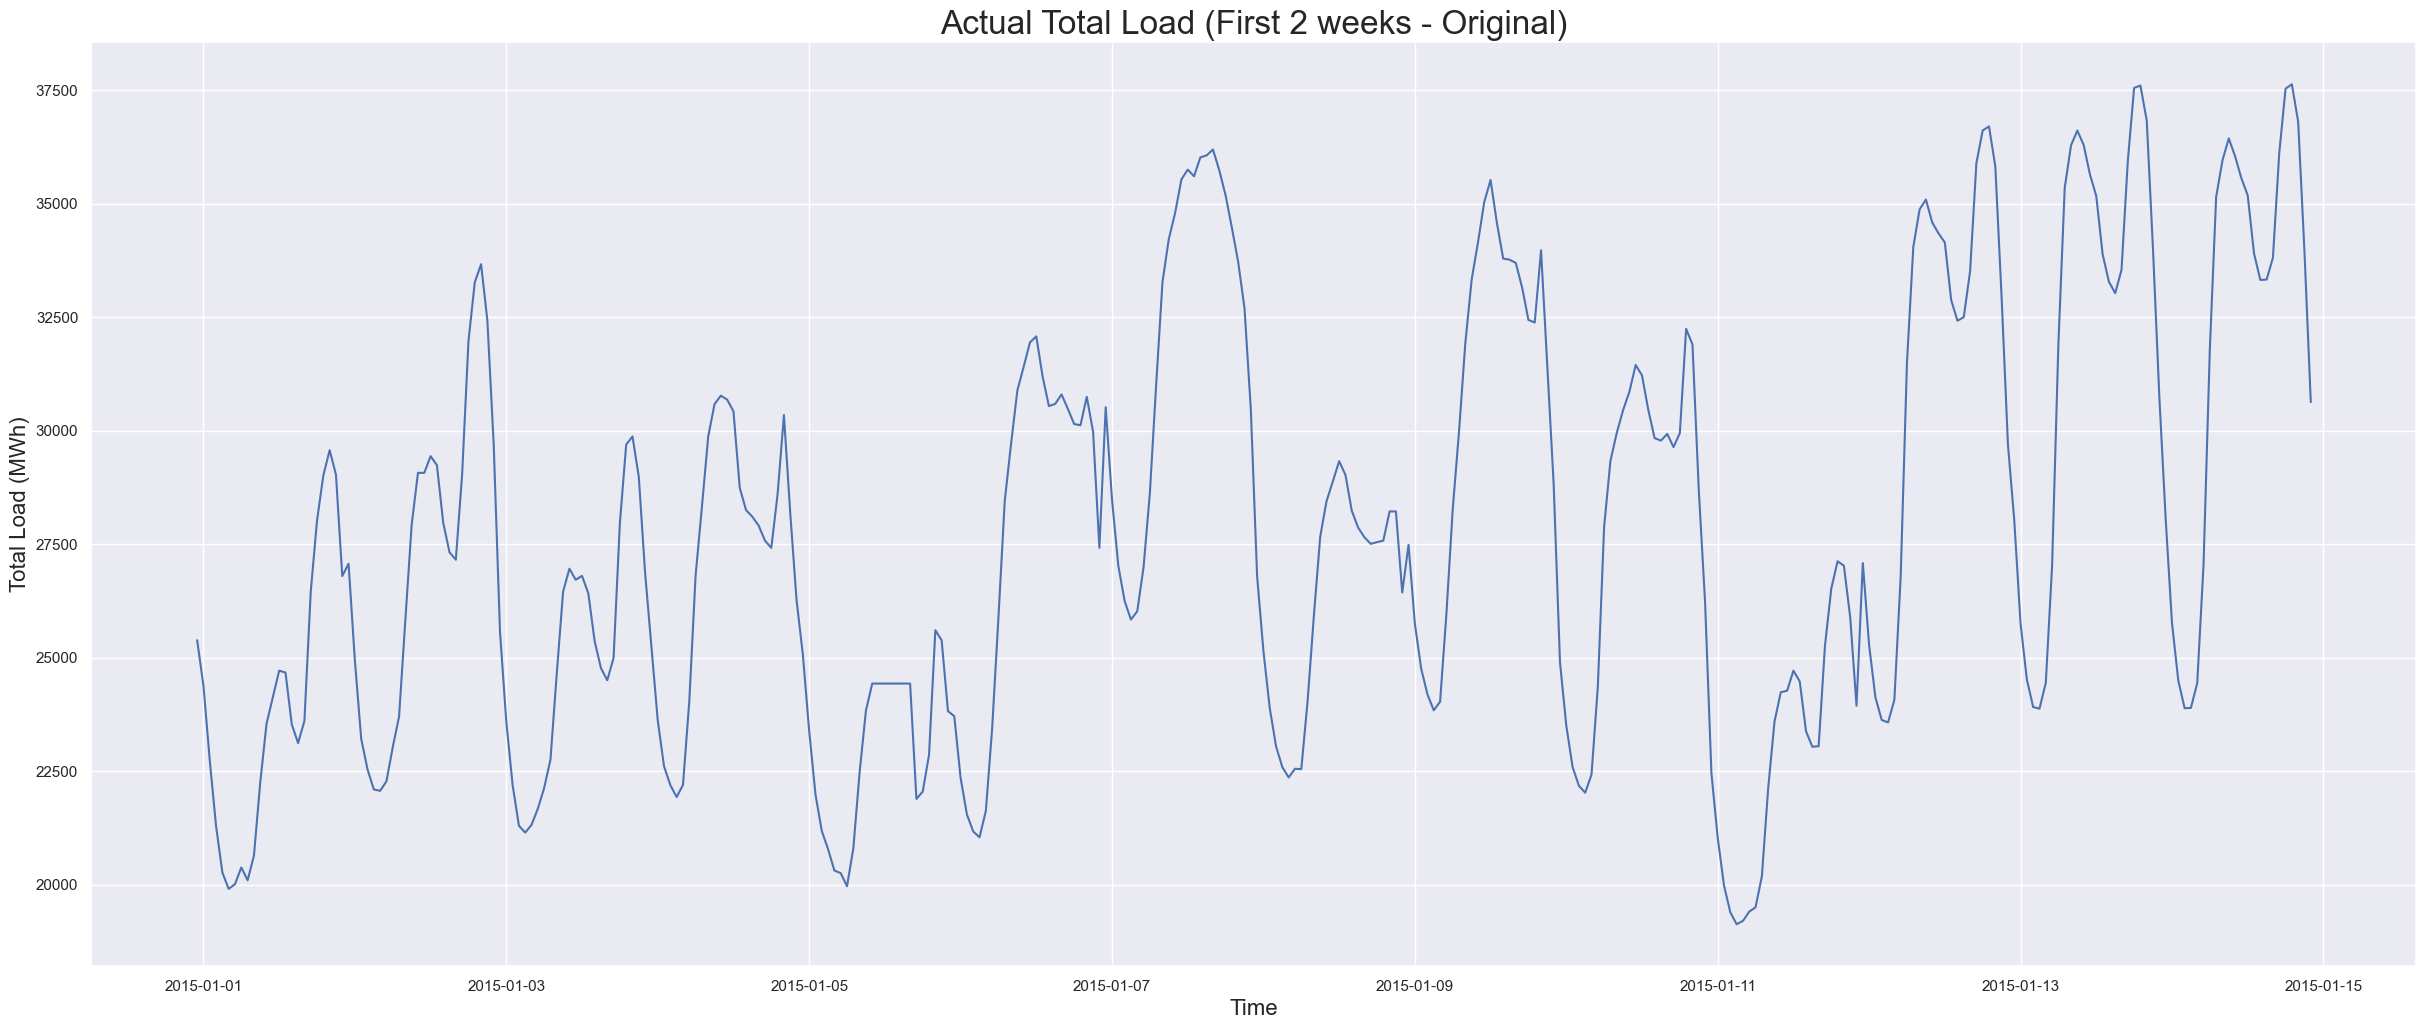

In [11]:
# Zoom into the plot of the hourly (actual) total load

ax = plot_series(df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [12]:
print("\n--- Creating Time-Based Predictor Features ---")

# I use the datetime index to extract seasonal and daily patterns.

df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Month'] = df.index.month

print("Created 'Hour', 'DayOfWeek', and 'Month' features.")
print(df[['Hour', 'DayOfWeek', 'Month']].head())


print("\n--- Creating Lagged Predictor Features ---")

# Energy load is highly dependent on the load 24 hours ago and 1 week (168 hours) ago.
# I use the .shift() function to pull previous values into the current row.

# Lag 24: Yesterday's load
df['Lag_24'] = df['total load actual'].shift(24) 

# Lag 168: Last week's load (7 days * 24 hours)
df['Lag_168'] = df['total load actual'].shift(168) 

print("Created 'Lag_24' and 'Lag_168' features.")

# The first 168 rows of our DataFrame will now have NaNs because there's no data 
# before them (due to the .shift(168)). I drop these incomplete rows.
print("\nDropping first 168 rows containing NaNs created by lagging...")
df.dropna(inplace=True)

# Final check of the data structure and size
print(f"\nFinal DataFrame size after cleaning and engineering: {df.shape[0]} rows, {df.shape[1]} columns.")
print("Feature Engineering Complete.")


--- Creating Time-Based Predictor Features ---
Created 'Hour', 'DayOfWeek', and 'Month' features.
                           Hour  DayOfWeek  Month
time                                             
2014-12-31 23:00:00+00:00    23          2     12
2015-01-01 00:00:00+00:00     0          3      1
2015-01-01 01:00:00+00:00     1          3      1
2015-01-01 02:00:00+00:00     2          3      1
2015-01-01 03:00:00+00:00     3          3      1

--- Creating Lagged Predictor Features ---
Created 'Lag_24' and 'Lag_168' features.

Dropping first 168 rows containing NaNs created by lagging...

Final DataFrame size after cleaning and engineering: 34880 rows, 26 columns.
Feature Engineering Complete.


In [13]:
print("--- Final Data Preparation ---")

TARGET_VARIABLE = 'total load actual'

# X (Features): Drop the target variable from the DataFrame to get all predictors
# We use .copy() to prevent SettingWithCopyWarning
X = df.drop(columns=[TARGET_VARIABLE]).copy()

# y (Target): Isolate the target variable
y = df[TARGET_VARIABLE]

print(f"X shape (Features): {X.shape}")
print(f"y shape (Target): {y.shape}")

# Scaling is crucial for many models (like Random Forest, which i use)
# StandardScaler sets mean=0 and std=1, ensuring balanced feature influence.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("\nFeatures scaled (StandardScaler applied).")

# I train on the oldest data and test on the newest.
# I reseerve reserve the last 15% of the data for testing our model performance.

test_size = 0.15 # Reserve the last 15% of data for testing (the future)
test_set_size = int(len(X_scaled) * test_size)
train_set_size = len(X_scaled) - test_set_size

X_train = X_scaled[:train_set_size]
X_test = X_scaled[train_set_size:]

y_train = y[:train_set_size]
y_test = y[train_set_size:]

print(f"\n--- Data Split Complete ---")
print(f"Training Set Size: {len(X_train)} (Past Data)")
print(f"Testing Set Size: {len(X_test)} (Future Data)")

--- Final Data Preparation ---
X shape (Features): (34880, 25)
y shape (Target): (34880,)

Features scaled (StandardScaler applied).

--- Data Split Complete ---
Training Set Size: 29648 (Past Data)
Testing Set Size: 5232 (Future Data)


In [14]:
print("Starting Random Forest Regressor (RFR) Training...")

# RFR is an ensemble model that uses bagging to reduce variance and avoid overfitting.
# n_estimators=100 is a good starting point, n_jobs=-1 uses all CPU cores for speed.
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)


# The .fit() method executes the training process.
rfr_model.fit(X_train, y_train)

print("RFR Training Complete. Model coefficients learned.")

# The model uses the features in X_test to forecast the 'total load actual' for the future period.
y_pred = rfr_model.predict(X_test)

# Evaluate Performance (need to see how well the forecast performed)
rfr_mse = mean_squared_error(y_test, y_pred)
rfr_rmse = np.sqrt(rfr_mse)
rfr_r2 = r2_score(y_test, y_pred)

print(f"\n--- RFR Performance on Test Set (Future Data) ---")
print(f"RMSE (Root Mean Squared Error): {rfr_rmse:.2f} MW")
print(f"R-squared (Variance Explained): {rfr_r2:.4f}")

Starting Random Forest Regressor (RFR) Training...
RFR Training Complete. Model coefficients learned.

--- RFR Performance on Test Set (Future Data) ---
RMSE (Root Mean Squared Error): 352.36 MW
R-squared (Variance Explained): 0.9941


In [15]:
print("Starting XGBoost Regressor (XGBR) Training...")

# I keep parameters simple for the baseline comparison
# n_jobs=-1 uses all CPU cores for fast training.
xgbr_model = XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)

# The fit method is the same as Scikit-learn
xgbr_model.fit(X_train, y_train)

print("XGBR Training Complete. Model coefficients learned.")

# 3. Make predictions on the unseen future data (X_test)
y_pred_xgbr = xgbr_model.predict(X_test)

# Evaluate Performance (Comparison Metrics)
xgbr_mse = mean_squared_error(y_test, y_pred_xgbr)
xgbr_rmse = np.sqrt(xgbr_mse)
xgbr_r2 = r2_score(y_test, y_pred_xgbr)

print(f"\n--- XGBR Performance on Test Set (Future Data) ---")
print(f"RMSE (Root Mean Squared Error): {xgbr_rmse:.2f} MW")
print(f"R-squared (Variance Explained): {xgbr_r2:.4f}")

# Store results for final comparison table
rfr_results = {'Model': 'Random Forest', 'RMSE': 352.36, 'R2': 0.9941} # the results from randowm forest regressor
xgbr_results = {'Model': 'XGBoost', 'RMSE': xgbr_rmse, 'R2': xgbr_r2}

print("\n--- Summary of Model Performance ---")
results_df = pd.DataFrame([rfr_results, xgbr_results])
print(results_df)

Starting XGBoost Regressor (XGBR) Training...
XGBR Training Complete. Model coefficients learned.

--- XGBR Performance on Test Set (Future Data) ---
RMSE (Root Mean Squared Error): 367.20 MW
R-squared (Variance Explained): 0.9936

--- Summary of Model Performance ---
           Model        RMSE        R2
0  Random Forest  352.360000  0.994100
1        XGBoost  367.201042  0.993577


Plotting actual vs. forecast on the test set...


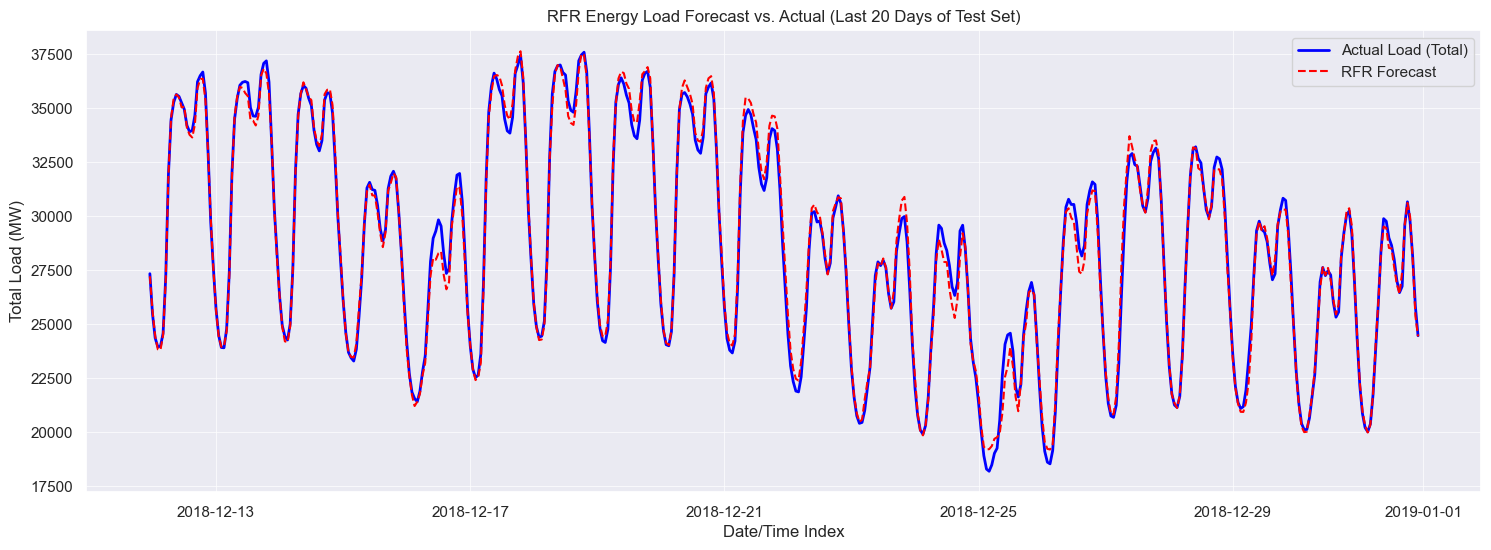

In [16]:
# I will plot the last part of the test set to clearly show forecast accuracy.
print("Plotting actual vs. forecast on the test set...")

# Plot range: Show the last 20 days (approx 20*24 hours) for clarity
PLOT_HOURS = 20 * 24 
end_index = len(y_test)
start_index = end_index - PLOT_HOURS

# Prepare data for plotting
actual_load = y_test.iloc[start_index:end_index]
rfr_forecast = y_pred[start_index:end_index] 

plt.figure(figsize=(18, 6))

# Actual Load 
plt.plot(actual_load.index, actual_load.values, 
         label='Actual Load (Total)', color='blue', linewidth=2)

# Random Forest Forecast (The best performing model)
# I plot the RFR forecast using the same index for alignment
plt.plot(actual_load.index, rfr_forecast, 
         label='RFR Forecast', color='red', linestyle='--', linewidth=1.5)

plt.title('RFR Energy Load Forecast vs. Actual (Last 20 Days of Test Set)')
plt.xlabel('Date/Time Index')
plt.ylabel('Total Load (MW)')
plt.legend()
plt.grid(True, which='major', linestyle='-', linewidth='0.5')
plt.show()

Plotting full historical context and forecast span...


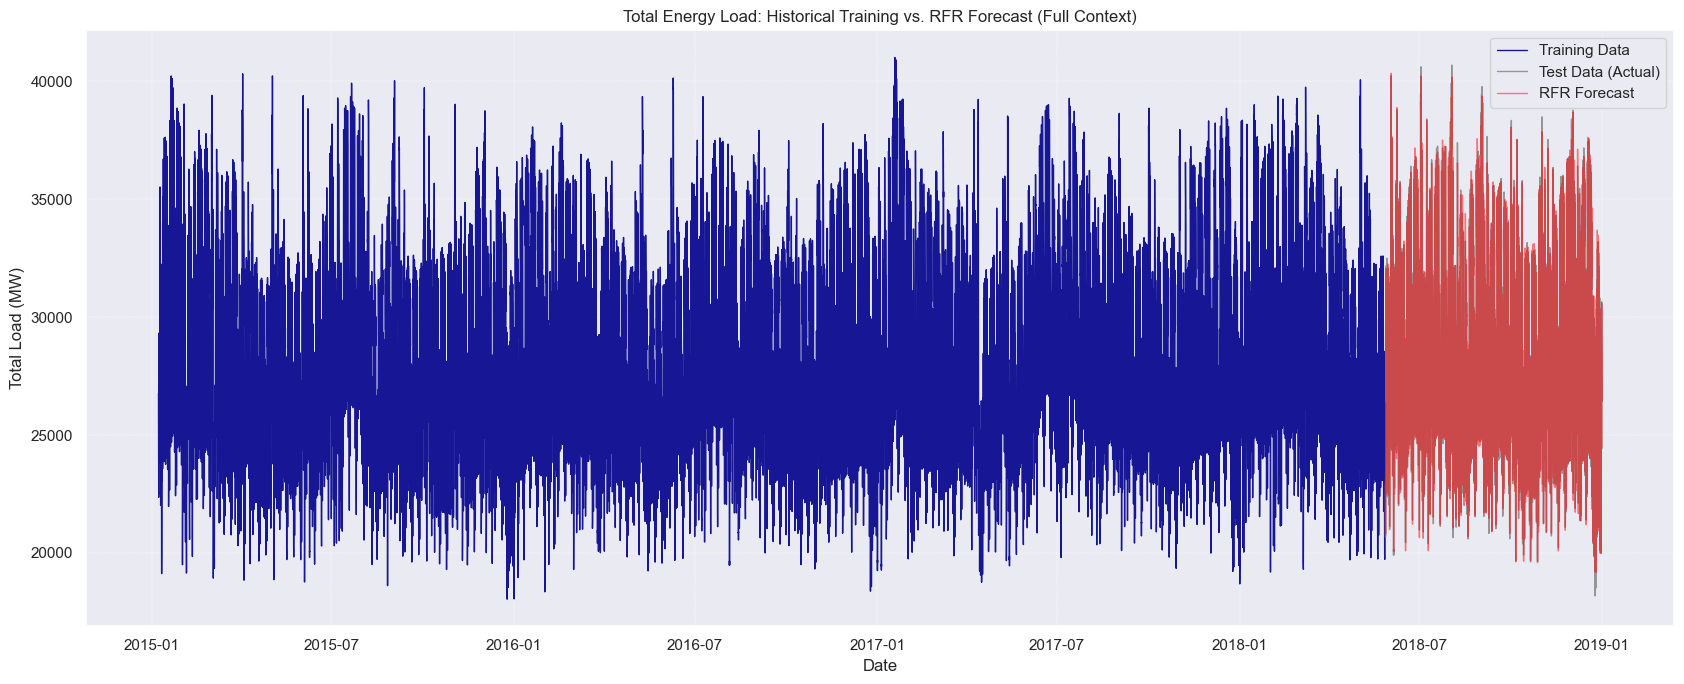

In [17]:
print("Plotting full historical context and forecast span...")

# This visualization replicates the wide view to show the context of the train/test split.

plt.figure(figsize=(17, 7))

#I plot the past data used for learning (X_train and y_train)
plt.plot(y_train.index, y_train, label='Training Data', color='darkblue', alpha=0.9, linewidth=1.0)

# I plot the actual true values the model tried to predict
plt.plot(y_test.index, y_test, label='Test Data (Actual)', color='gray', alpha=0.8, linewidth=1.0)

# I plot the RFR predictions on the test set. I use a transparent color to show the range.
plt.plot(y_test.index, y_pred, label='RFR Forecast', color='red', alpha=0.5, linewidth=1.0)

plt.title('Total Energy Load: Historical Training vs. RFR Forecast (Full Context)')
plt.xlabel('Date')
plt.ylabel('Total Load (MW)')
plt.legend()
plt.grid(True, which='major', linestyle='--', linewidth='0.3')
plt.tight_layout()
plt.show()

In [18]:
print("\n--- SDAILY PEAK LOAD FORECASTING ---")

# The stakeholder needs the maximum energy load for each day, not the hourly load.
# so i resample the hourly data (df) into a daily frequency (D) and take the maximum.

# Group by day and calculate the maximum for all columns
df_daily = df.resample('D').max()

print(f"Daily DataFrame size: {df_daily.shape[0]} days, {df_daily.shape[1]} columns.")

# Check for missing values created during resampling
print("\nChecking for NaNs in Daily Data:")
print(df_daily.isnull().sum())
df_daily.ffill(inplace=True)




--- SDAILY PEAK LOAD FORECASTING ---
Daily DataFrame size: 1455 days, 26 columns.

Checking for NaNs in Daily Data:
generation biomass                             0
generation fossil brown coal/lignite           0
generation fossil gas                          0
generation fossil hard coal                    0
generation fossil oil                          0
generation hydro pumped storage consumption    0
generation hydro run-of-river and poundage     0
generation hydro water reservoir               0
generation nuclear                             0
generation other                               0
generation other renewable                     0
generation solar                               0
generation waste                               0
generation wind offshore                       0
generation wind onshore                        0
forecast solar day ahead                       0
forecast wind onshore day ahead                0
total load forecast                            0
t

In [19]:
print("\n--- Preparing Daily Data for Peak Load Forecasting ---")

# The target is now the daily maximum total load actual.
TARGET_VARIABLE_DAILY = 'total load actual'

# X_daily (Features): Drop the target variable from the daily DataFrame to get all predictors
# and also drop the original time features (Hour, DayOfWeek, Month) as they represent HOURLY time, 
# and a simple Max() operation on them is not meaningful for a daily model. keeping only the Lagged features.
X_daily = df_daily.drop(columns=[TARGET_VARIABLE_DAILY, 'Hour', 'DayOfWeek', 'Month'])

# y_daily (Target): Isolate the new daily maximum target variable
y_daily = df_daily[TARGET_VARIABLE_DAILY]

print(f"Daily X shape (Features): {X_daily.shape}")
print(f"Daily y shape (Target): {y_daily.shape}")

# I create a NEW scaler for the daily data.
scaler_daily = StandardScaler()
X_daily_scaled = scaler_daily.fit_transform(X_daily)

print("Daily Features scaled (StandardScaler applied).")

# reserve the last 15% of the daily data for future testing.

test_size = 0.15 
test_set_size_daily = int(len(X_daily_scaled) * test_size)
train_set_size_daily = len(X_daily_scaled) - test_set_size_daily

X_train_daily = X_daily_scaled[:train_set_size_daily]
X_test_daily = X_daily_scaled[train_set_size_daily:]

y_train_daily = y_daily[:train_set_size_daily]
y_test_daily = y_daily[train_set_size_daily:]

print(f"\n--- Daily Data Split Complete ---")
print(f"Daily Training Set Size: {len(X_train_daily)} days (Past Data)")
print(f"Daily Testing Set Size: {len(X_test_daily)} days (Future Data)")


--- Preparing Daily Data for Peak Load Forecasting ---
Daily X shape (Features): (1455, 22)
Daily y shape (Target): (1455,)
Daily Features scaled (StandardScaler applied).

--- Daily Data Split Complete ---
Daily Training Set Size: 1237 days (Past Data)
Daily Testing Set Size: 218 days (Future Data)


In [20]:
print("\nStarting RFR Retraining for DAILY PEAK LOAD...")

rfr_model_daily = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rfr_model_daily.fit(X_train_daily, y_train_daily)

print("RFR Daily Peak Load Training Complete.")

y_pred_rfr_daily = rfr_model_daily.predict(X_test_daily)

# performance evaluation
rfr_mse_daily = mean_squared_error(y_test_daily, y_pred_rfr_daily)
rfr_rmse_daily = np.sqrt(rfr_mse_daily)
rfr_r2_daily = r2_score(y_test_daily, y_pred_rfr_daily)

print(f"\n--- RFR Daily Peak Load Performance ---")
print(f"RMSE (Root Mean Squared Error): {rfr_rmse_daily:.2f} MW")
print(f"R-squared (Variance Explained): {rfr_r2_daily:.4f}")


Starting RFR Retraining for DAILY PEAK LOAD...
RFR Daily Peak Load Training Complete.

--- RFR Daily Peak Load Performance ---
RMSE (Root Mean Squared Error): 397.23 MW
R-squared (Variance Explained): 0.9838


Plotting Daily Peak Load Forecast...


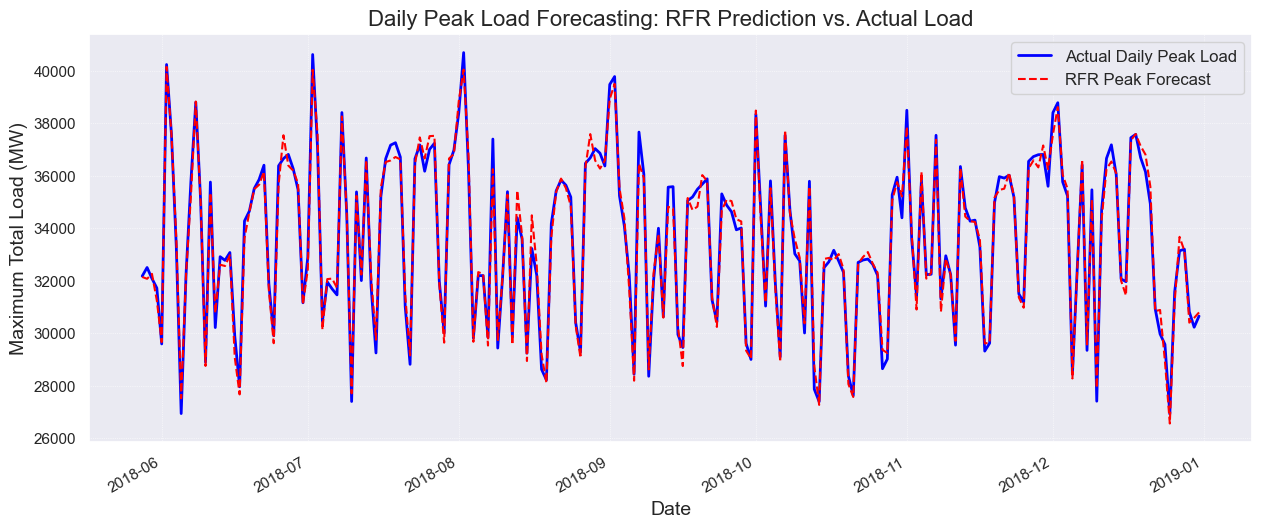

In [21]:
print("Plotting Daily Peak Load Forecast...")

daily_forecast_df = pd.DataFrame({
    'Actual_Peak': y_test_daily,
    'RFR_Forecast': y_pred_rfr_daily
})

plt.figure(figsize=(15, 6))

# Plot the actual daily peak load 
plt.plot(daily_forecast_df.index, daily_forecast_df['Actual_Peak'], 
         label='Actual Daily Peak Load', color='blue', linewidth=2)

# Plot the RFR forecast peak load 
plt.plot(daily_forecast_df.index, daily_forecast_df['RFR_Forecast'], 
         label='RFR Peak Forecast', color='red', linestyle='--', linewidth=1.5)


plt.title('Daily Peak Load Forecasting: RFR Prediction vs. Actual Load', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Maximum Total Load (MW)', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='major', linestyle=':', linewidth='0.5')

# Improve date formatting on the X-axis for readability

plt.gcf().autofmt_xdate() # Rotate dates slightly

plt.show()


--- FEATURE IMPORTANCE RANKING ---


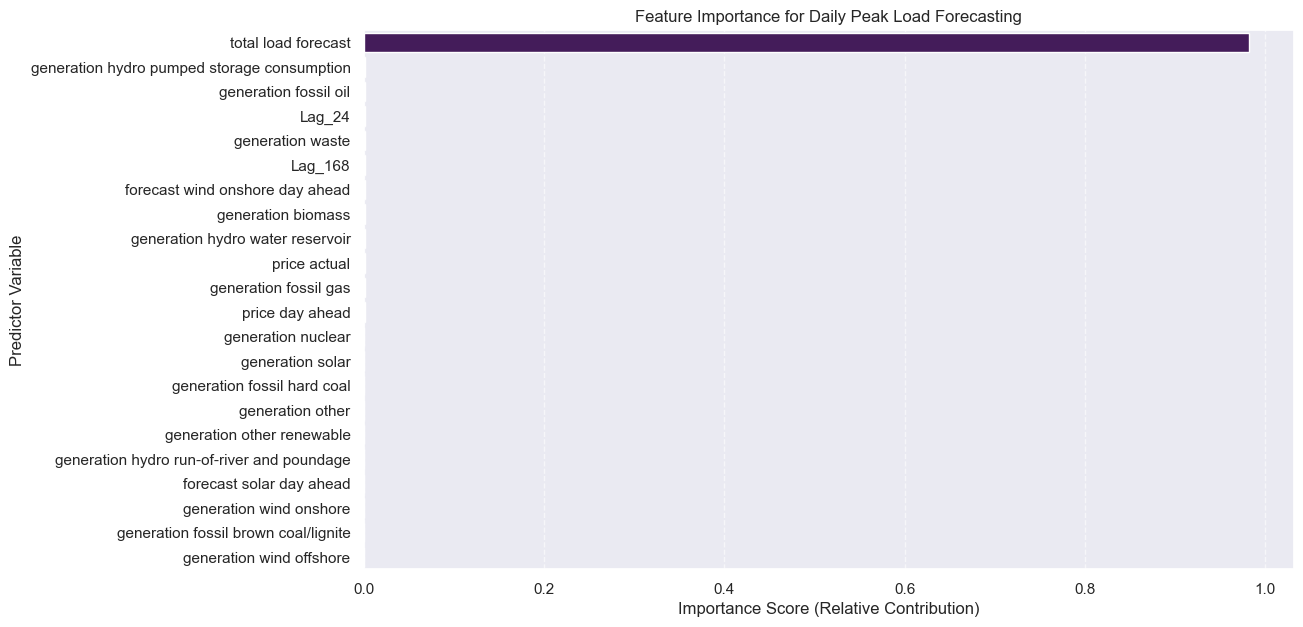


Top 5 Most Important Features:
total load forecast                            0.982361
generation hydro pumped storage consumption    0.001374
generation fossil oil                          0.001231
Lag_24                                         0.001151
generation waste                               0.001108
dtype: float64


In [22]:
print("\n--- FEATURE IMPORTANCE RANKING ---")

# Get feature importance from the trained RFR model
# The feature_importances_ attribute shows the relative importance of each predictor.
importances = rfr_model_daily.feature_importances_

feature_names = X_daily.columns
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)

plt.figure(figsize=(12, 7))
sns.barplot(x=feature_importance.values, y=feature_importance.index, hue=feature_importance.index, palette="viridis", legend=False)

plt.title('Feature Importance for Daily Peak Load Forecasting')
plt.xlabel('Importance Score (Relative Contribution)')
plt.ylabel('Predictor Variable')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

Starting 5-Year Recursive Forecast...


C:\Users\ABUBAKAR\AppData\Local\Temp\ipykernel_24160\4122864401.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_df.at[future_dates[0], 'Lag_24'] = df_daily['total load actual'][-24]
C:\Users\ABUBAKAR\AppData\Local\Temp\ipykernel_24160\4122864401.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  future_df.at[future_dates[0], 'Lag_168'] = df_daily['total load actual'][-168]
C:\Users\ABUBAKAR\AppData\Local\Temp\ipykernel_24160\4122864401.py:31: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) 

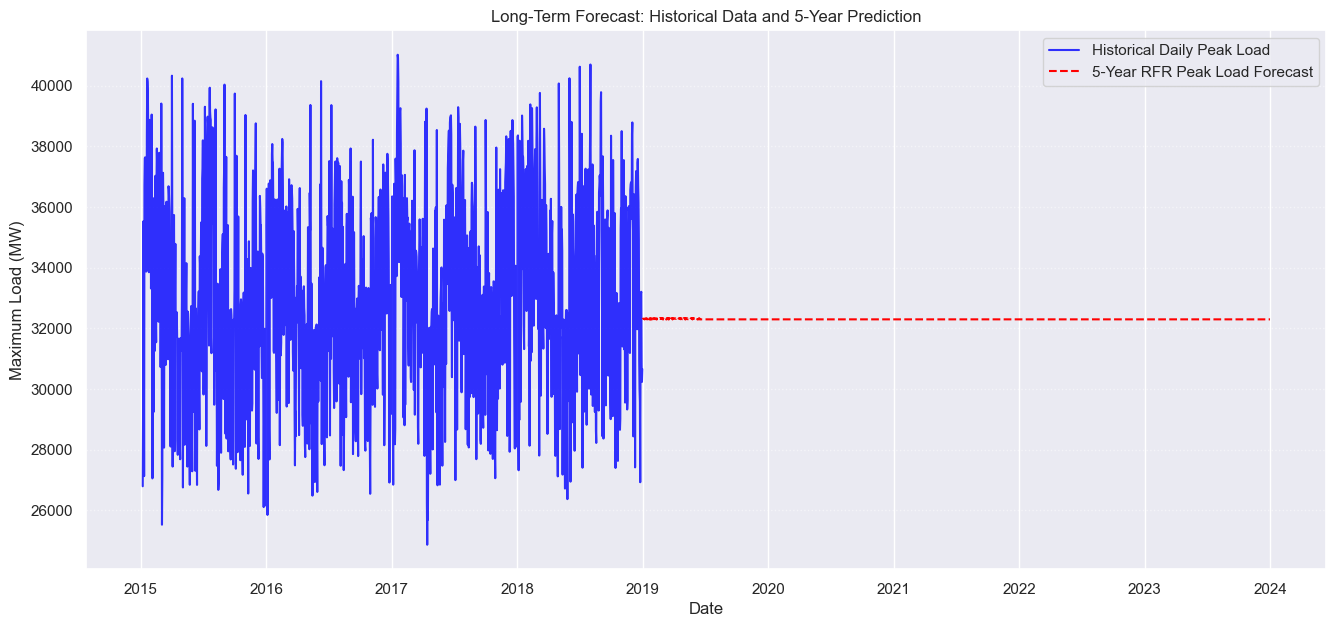


Long-term forecast completed successfully!


In [23]:
# taking the best model as the one trained on daily data
best_model = rfr_model_daily
scaler = scaler_daily 
X_cols = X_daily.columns # Get the list of features the model was trained on

print("Starting 5-Year Recursive Forecast...")

start_date = df_daily.index.max() + pd.Timedelta(days=1)
end_date = start_date + pd.DateOffset(years=5)

# Create a date range for the forecast period
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')
# Initialize future DataFrame with necessary columns
future_df = pd.DataFrame(index=future_dates, columns=X_cols)

# SEED THE FIRST ROW (Last known values from the historical data)
# Need the last 24 and 168 rows of the total load actual from the history (df_daily)
# only need the values for Lag_24 and Lag_168 for the first day.
future_df.at[future_dates[0], 'Lag_24'] = df_daily['total load actual'][-24]
future_df.at[future_dates[0], 'Lag_168'] = df_daily['total load actual'][-168]

# RECURSIVE PREDICTION LOOP (Predict one day and update the features for the next day)
predicted_values = []
for i, date in enumerate(future_df.index):
    # Prepare the features for the current day's prediction
    
    # Extract features (only Lag_24 and Lag_168)
    row_features = future_df.loc[date].to_frame().T 

    #  Fill any NaNs in the row using Forward Fill (needed for the recursive prediction)
    row_features = row_features.ffill(axis=1)

    # SCALE the features using the *TRAINED SCALER*
    # Matching the order of features used in training (X_daily.columns)
    X_pred_scaled = scaler.transform(row_features)
    
    # Predict the load
    prediction = best_model.predict(X_pred_scaled)[0]
    predicted_values.append(prediction)
    
    # UPDATE THE LAGS FOR THE NEXT DAY (The Recursion)
    if i < len(future_df) - 1:
        next_date = future_df.index[i + 1]
        
        # Lag_24 for tomorrow is today's predicted load
        future_df.at[next_date, 'Lag_24'] = prediction
        
        # Lag_168 for tomorrow is the Lag_168 from yesterday (which is the Lag_169 from today).
        # Manually shift the Lag_168 feature by 1 day back (taking the previous value from the Lag_168 column)
        future_df.at[next_date, 'Lag_168'] = future_df.at[date, 'Lag_168'] if i >= 168 else df_daily['total load actual'].iloc[-168 + i]


# FINAL PLOT
future_df['predicted_load'] = predicted_values

plt.figure(figsize=(16, 7))
plt.plot(df_daily.index, df_daily[TARGET_VARIABLE_DAILY], 
         label='Historical Daily Peak Load', color='blue', alpha=0.8)
plt.plot(future_df.index, future_df['predicted_load'], 
         label='5-Year RFR Peak Load Forecast', color='red', linestyle='--')

plt.title('Long-Term Forecast: Historical Data and 5-Year Prediction')
plt.xlabel('Date')
plt.ylabel('Maximum Load (MW)')
plt.grid(True, axis='y', linestyle=':', alpha=0.5)
plt.legend()
plt.show()

print("\nLong-term forecast completed successfully!")


--- Correlation Analysis of Predictor Variables ---


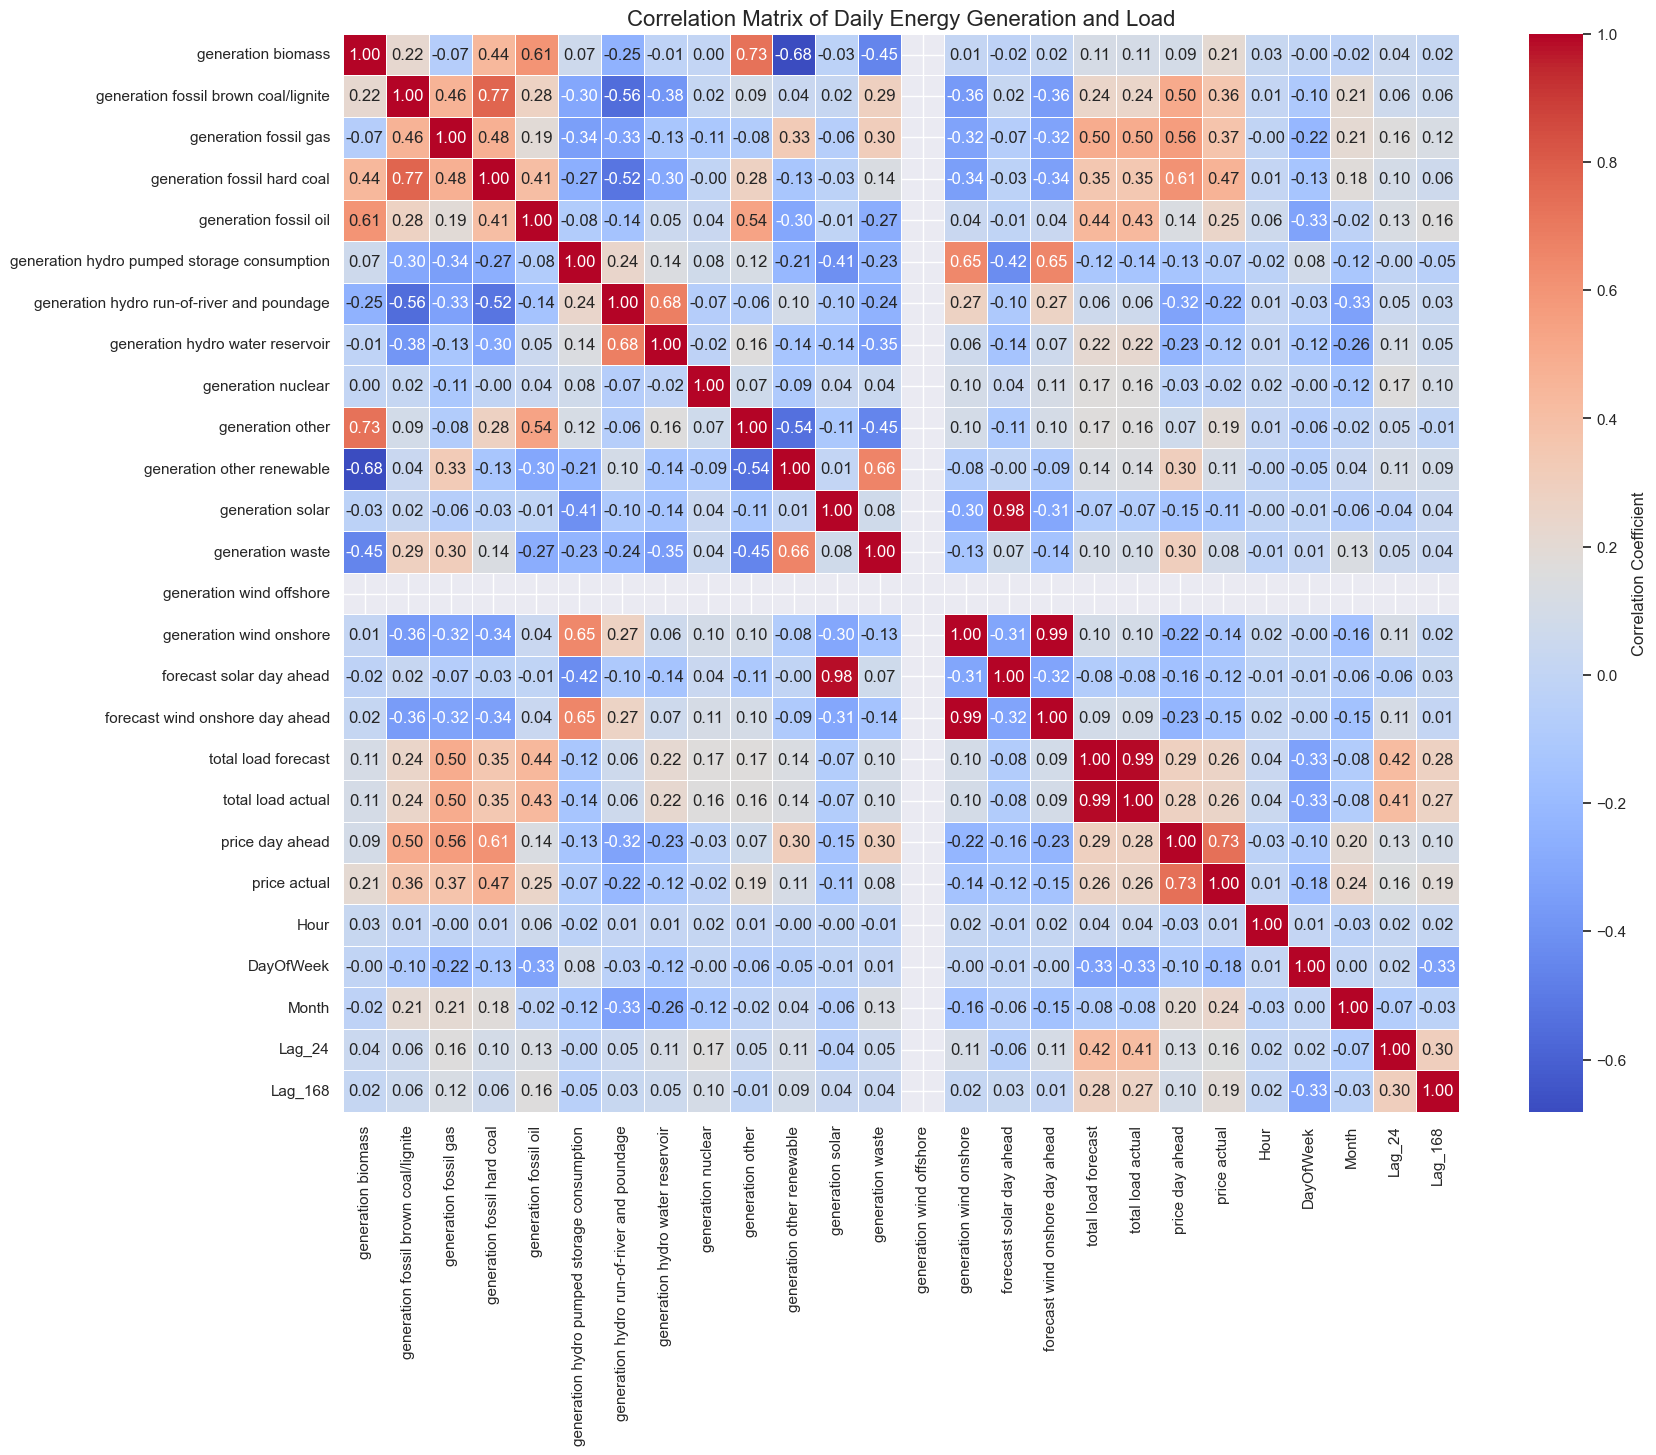


REVIEW: Look for values close to 1 or -1 for strong correlations.
Strongest Predictor-Target correlation is with the engineered Lag features.
Strongest Predictor-Predictor correlation indicates potential multicollinearity.


In [27]:
print("\n--- Correlation Analysis of Predictor Variables ---")

# I use THE fully cleaned and resampled daily data (df_daily) for this analysis.
# The correlation matrix includes THE target variable and all predictors.
correlation_matrix = df_daily.corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(18, 14))
sns.heatmap(correlation_matrix, 
            annot=True,              # Display the r values on the map
            fmt=".2f",               # Format r values to two decimal places
            cmap='coolwarm',         # Use a color scheme that highlights positive (red) and negative (blue) correlations
            linewidths=0.5,
            cbar_kws={'label': 'Correlation Coefficient'})

plt.title('Correlation Matrix of Daily Energy Generation and Load', fontsize=16)
plt.show()

#
print("\nREVIEW: Look for values close to 1 or -1 for strong correlations.")
print("Strongest Predictor-Target correlation is with the engineered Lag features.")
print("Strongest Predictor-Predictor correlation indicates potential multicollinearity.")

In [28]:
print("\n--- Top Correlated Features---")
correlations = correlation_matrix['total load actual'].drop('total load actual')
# Sort the correlations by absolute magnitude and get the top 6
top_6_parameters = correlations.abs().sort_values(ascending=False).head(6)

# Print the top 6 correlated parameters
print(top_6_parameters)


--- Top Correlated Features---
total load forecast            0.989977
generation fossil gas          0.499066
generation fossil oil          0.431135
Lag_24                         0.410695
generation fossil hard coal    0.348970
DayOfWeek                      0.332893
Name: total load actual, dtype: float64



--- Plotting Monthly Average Generation (EDA) ---


C:\Users\ABUBAKAR\AppData\Local\Temp\ipykernel_24160\4186591761.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_daily[sources_to_plot].resample('M').mean()


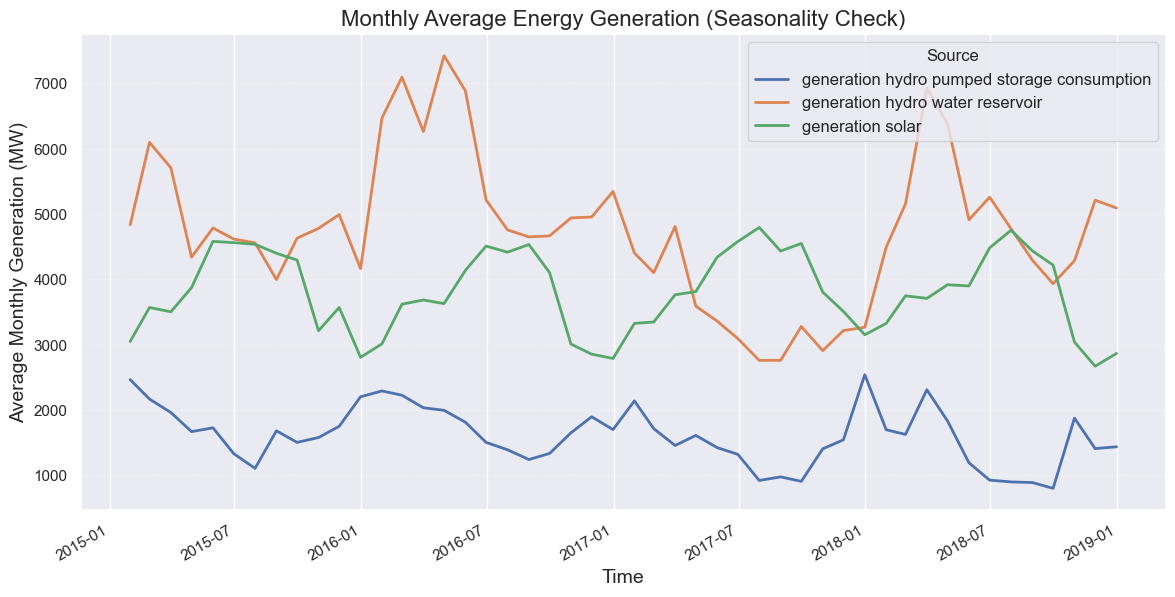

Monthly seasonality plot complete.


In [24]:
print("\n--- Plotting Monthly Average Generation (EDA) ---")

# Using the cleaned daily data (df_daily) for a smoother monthly look.
sources_to_plot = [
    'generation hydro pumped storage consumption', 
    'generation hydro water reservoir', 
    'generation solar'
]

# Resample the daily data into monthly averages ('M')
monthly_data = df_daily[sources_to_plot].resample('M').mean()

# Plot the time series
plt.figure(figsize=(14, 7))

# Plot each column individually
for column in monthly_data.columns:
    plt.plot(monthly_data.index, monthly_data[column], label=column, linewidth=2)

plt.title('Monthly Average Energy Generation (Seasonality Check)', fontsize=16)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Average Monthly Generation (MW)', fontsize=14)
plt.grid(True, axis='y', linestyle=':', alpha=0.5)
plt.legend(title='Source', fontsize=12)

# Improve date formatting on the X-axis
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gcf().autofmt_xdate()

plt.show()

print("Monthly seasonality plot complete.")

As above visualisation highlights the energy generation for the sources mentioned in labels in Valencia,for our stakeholders i suggest to look into the "Hydro Pumped Storage", "Hydro Water Reservoir" and "Solar Generation" renewable energy sources for investment in sustainable energy generation. If provided with similar data from utility companies and energy generation plants, my model could forecast the energy consumption and we could also suggest for different renewable source based on data analysis of provided data. For efficient forecasting i would ask stakeholders to provide additional following data: 1)Area Population Data. 2)Energy consumption history for appliances used in the region. 3)Utility Bills Pricing Data 4)Additional Data Points